load datasets - OK

load model
create simple - train function 1 sfew, 2 expw
create test function
create dann function

source = 'sfew'
target = 'expw'

In [37]:
from ds_sfew import DatasetSFEW
from ds_expw import EXPW
from utils import show_batch
from model_DANN import DANN
import torch
import torch.nn as nn
from run_config import RunConfig
import torch.optim as optim
from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
from data_config import DataConfig
import numpy as np
from torch.autograd import Variable #for EWC
from torch.autograd import Function #for EWC

### SFEW Dataset

self.BASE_PATH -dataset,self.EXTRACT_DIR-dataset\sfew,self.ZIP_FILE_PATH - dataset\SFEW_2.zip 
Directory dataset\sfew already exists.
Files exist in dataset\sfew, extraction not done
Unzipped Files already exist in dataset\sfew\Train, not extracted
Unzipped Files already exist in dataset\sfew\Val, not extracted
 length of SFEW dataset : 958


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


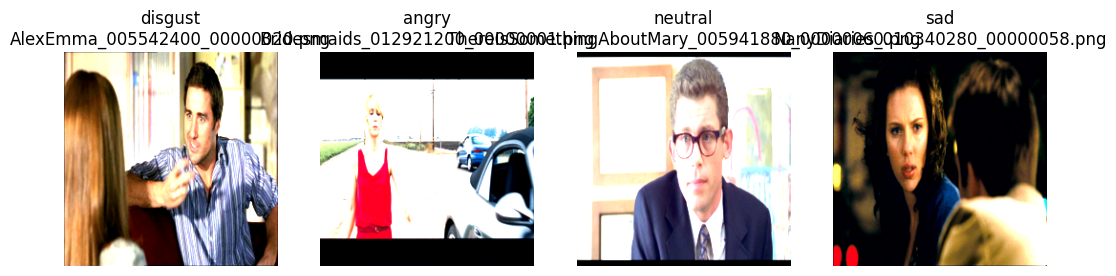

In [2]:
sfew = DatasetSFEW()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')
show_batch(sfew_train_loader,sfew.labels,4)

### EXPW Dataset

In [3]:
#default dataloader
expw_obj   = EXPW()
expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

Directory dataset\expwds already exists.
Directory dataset\expwds already exists.
 length of EXPW dataset : 54476 , 54476


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


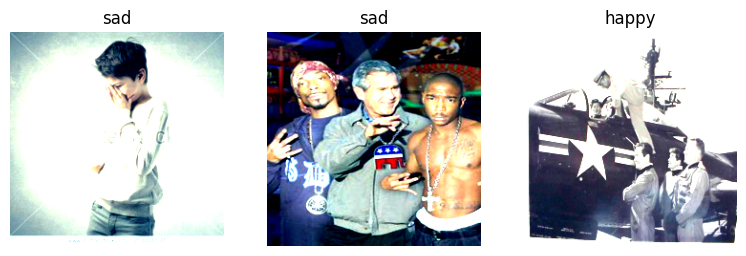

In [4]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

### Initializing Model

In [24]:
model = DANN(num_classes=7, dropout=0.1)

In [25]:
model

DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

### Training - one forward pass

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cpu


In [8]:
data_loader = {'source_train_loader':sfew_train_loader,
               'source_val_loader':sfew_val_loader,
               'target_train_loader':expw_train_loader,
               'target_val_loader':expw_val_loader}
model = model.to(device)
for name, data_loader in data_loader.items(): #[sfew_train_loader,sfew_val_loader,expw_train_loader,expw_val_loader]:
    print('-'*80)
    print(name)
    
    batch = next(iter(data_loader)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
    images, labels = batch[0].to(device), batch[1].to(device)
    print(images.shape)

    x_labels, x_domains, x_features = model(images)

    print("input_labels\n", labels)
    print(x_labels.shape, x_domains.shape, x_features.shape)
    print("x_output_labels\n", x_labels)
    print("x_output_domains\n",x_domains)

--------------------------------------------------------------------------------
source_train_loader
torch.Size([4, 3, 224, 224])
input_labels
 tensor([[0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]])
torch.Size([4, 7]) torch.Size([4, 2]) torch.Size([4, 1000])
x_output_labels
 tensor([[-0.0257,  0.0780, -0.0101,  0.0618, -0.0446, -0.1625,  0.0269],
        [-0.0835,  0.1205, -0.0751, -0.1210, -0.0575, -0.1778,  0.1491],
        [-0.0066,  0.0013,  0.0588,  0.0631, -0.0157, -0.1449,  0.1253],
        [-0.0459,  0.0614, -0.0438,  0.1146,  0.0430, -0.1563, -0.0684]],
       grad_fn=<AddmmBackward0>)
x_output_domains
 tensor([[-0.0662,  0.0833],
        [ 0.0367, -0.0325],
        [-0.0618, -0.0319],
        [ 0.0020,  0.0373]], grad_fn=<AddmmBackward0>)
--------------------------------------------------------------------------------
source_val_loader
torch.Size([4, 3, 224, 224])
input_labels
 t

### Weight Initialization

In [23]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# initializating weights using xavier normal
def weights_init(m):
    if isinstance(m, nn.Conv2d):
      # nn.init.xavier_normal_(m.weight)
      pass # not initialising Conv layers as they are pretrained
    elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight) # Linear layers are added on
      nn.init.zeros_(m.bias)

### Non DANN Training

#### Non DANN Traning Function

In [27]:
#@title Typical Training Function with Learning rate

def train_model(model,device, data_loader, optimizer, epoch, 
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')

    model.train() # setting model to training
    model.to(device)
    
    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    
    for batch_idx, batch in enumerate(pbar):
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels

        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Batch_id={batch_idx+1} Epoch Average loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')
    
    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr

#### Non DANN Testing Function (used for all)

In [28]:
def get_correct_predictions(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    # print(prediction)
    # print(prediction.argmax(dim=1))
    # print(f'labels = {labels}, labels.argmax ={labels.argmax(dim=1)}')
    # # print(prediction.argmax(dim=1).eq(labels))
    # # print(prediction.argmax(dim=1).eq(labels).sum())
    # # print(prediction.argmax(dim=1).eq(labels).sum().item())
    # # return prediction.argmax(dim=1).eq(labels).sum().item()
    # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum())
    # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item())
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [29]:


#@title Typical Test Function
def test_model(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)
            
            class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_predictions(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss



### Non DANN Execute

In [13]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANN(num_classes=7)
non_dann_model = non_dann_model.to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr) 

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs 

# Epochs
EPOCHS = runconfig.NUM_EPOCHS

print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = sfew_train_loader,
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    #TODO: ADD SCHEDULER

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model, 
                                    device= device, 
                                    data_loader = sfew_val_loader, 
                                    class_loss_function = criterion_class
                                    )
    
    val_losses.append(avg_epoch_val_loss)
    
correct_source, test_loss_source = test_model(model= non_dann_model, 
                                    device= device, 
                                    data_loader = sfew_val_loader, # source val loader
                                    class_loss_function = criterion_class)

accuracy_source = correct_source / len(sfew_val_loader.dataset)

correct_target, test_loss_target = test_model(model= non_dann_model, 
                                    device= device, 
                                    data_loader = expw_val_loader, # target val loader
                                    class_loss_function = criterion_class)

accuracy_target = correct_target / len(expw_val_loader.dataset)

dict_non_dann_losses_list_sfew_expw = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source, 
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : 0,
                                       'test_accuracy_source' : accuracy_source,
                                       'test_accuracy_target':accuracy_target  }       


------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1
epoch = 1...in training function


Loss=1.6464303731918335 Batch_id=240 Epoch Average loss=0.47361228 LR=0.001000: 100%|██████████| 240/240 [12:22<00:00,  3.09s/it]


Test / Val: Average loss: 0.4739, Accuracy: 77/436 (17.66%)

Test / Val: Average loss: 0.4739, Accuracy: 77/436 (17.66%)



In [14]:
print(dict_non_dann_losses_list_sfew_expw)

{'train_losses': [0.47361228], 'val_losses': [0.4739366050707091], 'test_loss': 0.47393660370363005, 'epoch_convergence': 0}


#### Saving NON DANN Model

In [15]:
# # TODO: get this information from config
# MODEL_DIR = "models"
# NON_DANN_SFEW_DIR = Path(MODEL_DIR,"non_dann_sfew")
# NON_DANN_SFEW_DIR

WindowsPath('models/non_dann_sfew')

In [8]:
dataconfig = DataConfig()
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = Path(dataconfig.NON_DANN_SFEW_DIR)
print(NON_DANN_SFEW_DIR)
NON_DANN_SFEW_DIR.exists()

models\non_dann_sfew


True

In [53]:
model_name = "non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not NON_DANN_SFEW_DIR.exists():
    # Create the directory
    NON_DANN_SFEW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {NON_DANN_SFEW_DIR} created successfully.')
else:
    print(f'Directory {NON_DANN_SFEW_DIR} already exists.')
    
try:
    torch.save(non_dann_model.state_dict(), Path(NON_DANN_SFEW_DIR,model_name))
    print(f'{model_name} SAVED at {Path(NON_DANN_SFEW_DIR,model_name)}!')
except:
    print(f'Problem in saving {model_name}, NOT SAVED!')

Directory models\non_dann_sfew already exists.


### Plotting Training and Validation Loss Function




In [16]:
#@title Plotting Training and Validation Loss Function
def plot_loss_curves(dict_non_dann_losses_list_sfew, mode = "train_losses"):
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(5, 1, 2)
    # for embedding in dict_emb_file.keys(): 
    list1_to_plot= dict_non_dann_losses_list_sfew[mode]
    plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend(loc = 'upper right')
    plt.title(name + " "+mode)
    plt.show()

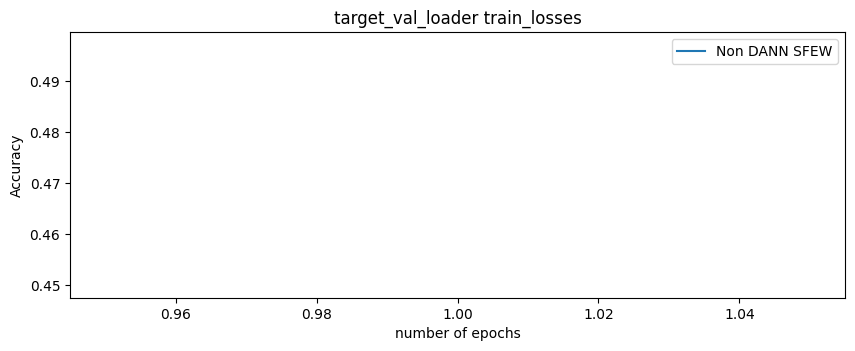

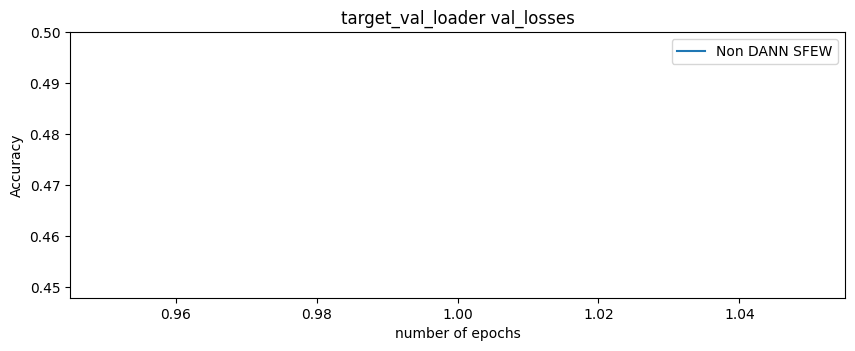

In [17]:
plot_loss_curves(dict_non_dann_losses_list_sfew,mode='train_losses')
plot_loss_curves(dict_non_dann_losses_list_sfew,mode='val_losses')

### DANN Training
It might be a good idea to copy weights of non-dann model.
As the weights would be optimized for classification already

In [30]:
model_name = "non_dann_sfew_12_12.pt"

In [31]:
#@title Loading NON DANN Model for DANN and DANN EWC 

loaded_model_non_dann = DANN(num_classes=7) # skeleton copy
loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = loaded_model_non_dann # saves training time - check with all team members
model_dann_ewc = loaded_model_non_dann # saves training time - check with all team members

# print(model_dann)

In [32]:
#checking if the models are same weights, i.e. copy has worked fine
for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
        print ('False')
print ('True')

NameError: name 'non_dann_model' is not defined

#### DANN Execution Function
It combines both training and testing

In [33]:
#@title DANN Execution (training and testing) Function without Learning rate

def execute_dann(model,device, 
                     source_train_loader, source_val_loader, 
                     target_train_loader, target_val_loader,
                     optimizer, 
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss() ):
    
    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = n_epochs
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]

    
    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0 
        
        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]
 
            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}
            
            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss
            

            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()
            
            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model, 
                                                device= device, 
                                                data_loader = source_val_loader, 
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        
        #TODO: Early Stopping
    
    # Testing when the training is over - completed or early stopped
    correct_source, test_loss_source = test_model(model= model, 
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)        
    
    correct_target, test_loss_target = test_model(model= model, 
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)
    
    accuracy_target = correct_target / len(target_val_loader.dataset)
    
    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source, 
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target}       
    
    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses


    


#### DANN Execute

In [34]:
runconfig = RunConfig()
lr_dann = runconfig.inital_lr
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
print(f'------------training started for DANN Model ------------------')

dann_model_sfew_expw , dict_dann_losses_list_sfew_expw= execute_dann(model=model_dann,
                            device=device,
                            source_train_loader = sfew_train_loader, 
                            source_val_loader = sfew_val_loader, 
                            target_train_loader = expw_train_loader,
                            target_val_loader = expw_val_loader,
                            optimizer = optimizer_dann,  
                            n_epochs = n_epochs,
                            class_loss_function = runconfig.criterion_class, 
                            domain_loss_function = runconfig.criterion_domain )

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function


Epoch [1/2] Step [1/240]: loss_total=3.3461 / domain_loss_target=0.6872 / domain_loss_source=0.7076 / task_loss=1.9513 / domain_loss=2.6589 / alpha=0.0000
Epoch [1/2] Step [11/240]: loss_total=2.6312 / domain_loss_target=0.6991 / domain_loss_source=0.6984 / task_loss=1.2337 / domain_loss=1.9322 / alpha=0.1038
Epoch [1/2] Step [21/240]: loss_total=3.2049 / domain_loss_target=0.6680 / domain_loss_source=0.6739 / task_loss=1.8630 / domain_loss=2.5369 / alpha=0.2054
Epoch [1/2] Step [31/240]: loss_total=2.9953 / domain_loss_target=0.7015 / domain_loss_source=0.7220 / task_loss=1.5718 / domain_loss=2.2938 / alpha=0.3027
Epoch [1/2] Step [41/240]: loss_total=3.2556 / domain_loss_target=0.7078 / domain_loss_source=0.6769 / task_loss=1.8709 / domain_loss=2.5478 / alpha=0.3941
Epoch [1/2] Step [51/240]: loss_total=2.7035 / domain_loss_target=0.6727 / domain_loss_source=0.6567 / task_loss=1.3741 / domain_loss=2.0308 / alpha=0.4783
Epoch [1/2] Step [61/240]: loss_total=3.4133 / domain_loss_target

#### DANN - Plotting Traning and Validation

In [ ]:
print(f'Test Loss on Source : {dict_dann_losses_list_sfew_expw['test_loss_source']}')
print(f'Test Loss on Target : {dict_dann_losses_list_sfew_expw['test_loss_target']}')

plot_loss_curves(dict_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_dann_losses_list_sfew_expw,mode='val_losses')
plot_loss_curves(dict_dann_losses_list_sfew_expw,mode='list_alpha')

#### Saving DANN Model


In [ ]:
dann_model_sfew_expw

In [53]:

dann_model_name = "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt" 
print(dann_model_name)

from data_config import DataConfig
dataconfig_1 = DataConfig()
print(dataconfig_1)
MODEL_DIR = dataconfig_1.MODEL_DIR

try:
    DANN_SFEW_EXPW_DIR = Path(dataconfig_1.DANN_SFEW_EXPW_DIR)
except:
    DANN_SFEW_EXPW_DIR =Path(dataconfig_1.MODEL_DIR,"dann_sfew_expw")
    

if not DANN_SFEW_EXPW_DIR.exists():
    # Create the directory
    DANN_SFEW_EXPW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_SFEW_EXPW_DIR} created successfully.')
else:
    print(f'Directory {DANN_SFEW_EXPW_DIR} already exists.')


try:      
    torch.save(dann_model_sfew_expw.state_dict(), Path(DANN_SFEW_EXPW_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_SFEW_EXPW_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')


dann_sfew_expw_20_12.pt
models\dann_sfew_expw
Directory models\dann_sfew_expw already exists.


### DANN - EWC 

In [54]:
model_dann_ewc

DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

#### EWC CODE

In [55]:
#@title EWC Code

from torch.autograd import Variable
from torch.autograd import Function

def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module, 
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function
        
        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)
        
        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### EWC DANN Execute Function

In [59]:
ewc_object = EWC(deepcopy(model_dann_ewc),data_loader=sfew_train_loader, device=device, class_loss_function=runconfig.criterion_class)
# ewc_object.__repr__

----------MODEL--------
 DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

<method-wrapper '__repr__' of EWC object at 0x000001DD37E10A30>

In [63]:
#@title DANN EWC Execution (training and testing) Function without Learning rate


def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader, 
                     target_train_loader, target_val_loader,
                     optimizer, 
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     ):
    
    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = n_epochs
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model)
    model = deepcopy(model).to(device) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    ewc_object = EWC(deepcopy(model),
                     data_loader=source_train_loader, 
                     device=device, 
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty

    
    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0 
        
        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]
 
            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}
            
            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss
            

            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()
            
            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model, 
                                                device= device, 
                                                data_loader = source_val_loader, 
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        
        #TODO: Early Stopping
    
    # Testing when the training is over - completed or early stopped
    correct_source, test_loss_source = test_model(model= model, 
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)
    
    accuracy_source = correct_source / len(source_val_loader.dataset)
    
    correct_target, test_loss_target = test_model(model= model, 
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)
    
    accuracy_target = correct_target / len(target_val_loader.dataset)

    
    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source, 
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target  }       
    
    print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses


    


### EWC DANN Execute

In [64]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr/10
optimizer_ewc_dann = optim.SGD(model_dann.parameters(), lr = lr_ewc_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)

print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model_sfew_expw , dict_ewc_dann_losses_list_sfew_expw= execute_dann_ewc(model=model_dann,
                                                                                 device=device,
                                                                                 source_train_loader = sfew_train_loader,
                                                                                 source_val_loader = sfew_val_loader,
                                                                                 target_train_loader = expw_train_loader,
                                                                                 target_val_loader = expw_val_loader,
                                                                                 optimizer = optimizer_ewc_dann,  
                                                                                 n_epochs = n_epochs,
                                                                                 class_loss_function = runconfig.criterion_class,
                                                                                 domain_loss_function = runconfig.criterion_domain,
                                                                                 EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                                                )

0.4
------------training started for EWC DANN Model ------------------


----------MODEL--------
 DANN(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (dow

#### EWC Plotting Training and Validation 

In [ ]:
print(f'Test Loss on Source : {dict_ewc_dann_losses_list_sfew_expw['test_loss_source']}')
print(f'Test Loss on Target : {dict_ewc_dann_losses_list_sfew_expw['test_loss_target']}')

plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='val_losses')
plot_loss_curves(dict_ewc_dann_losses_list_sfew_expw,mode='list_alpha')

#### Saving EWC DANN Model


In [ ]:
ewc_dann_model_sfew_expw

In [ ]:

ewc_dann_model_name = "ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt" 
print(ewc_dann_model_name)

from data_config import DataConfig
dataconfig_2 = DataConfig()
print(dataconfig_2)
MODEL_DIR = dataconfig_2.MODEL_DIR

try:
    EWC_DANN_SFEW_EXPW_DIR = Path(dataconfig_2.EWC_DANN_SFEW_EXPW_DIR)
except:
    EWC_DANN_SFEW_EXPW_DIR =Path(dataconfig_2.MODEL_DIR,"ewc_dann_sfew_expw")
    

if not EWC_DANN_SFEW_EXPW_DIR.exists():
    # Create the directory
    EWC_DANN_SFEW_EXPW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_SFEW_EXPW_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_SFEW_EXPW_DIR} already exists.')

try:
    torch.save(ewc_dann_model_sfew_expw.state_dict(), Path(EWC_DANN_SFEW_EXPW_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_SFEW_EXPW_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')


## Comparision of performance NON_DANN, DANN and EWC_DANN
source = SFEW, target = EXPW

In [ ]:
import pandas as pd

source= 'sfew'
target = 'expw'

col_name = ['model_class','trained_on','accuracy_source','accuracy_target']
df_nice_results = pd.DataFrame(column = col_name)

dict_input = {'model_class': 'Non_DANN', 
                   'trained_on': str(source)+" source",
                   'accuracy_source':dict_non_dann_losses_list_sfew_expw['test_accuracy_source'],
                   'accuracy_target':dict_non_dann_losses_list_sfew_expw['test_accuracy_target']}
df_nice_results.append(dict_input,ignore_index=True)

dict_input = {'model_class': 'DANN', 
                   'trained_on': str(source)+" source +\n"+str(target) + " target",
                   'accuracy_source':dict_dann_losses_list_sfew_expw['test_accuracy_source'],
                   'accuracy_target':dict_dann_losses_list_sfew_expw['test_accuracy_target']}

df_nice_results.append(dict_input, ignore_index=True)

dict_input = {'model_class': 'EWC_DANN', 
                   'trained_on': str(source)+" source +\n"+str(target) + " target",
                   'accuracy_source':dict_ewc_dann_losses_list_sfew_expw['test_accuracy_source'],
                   'accuracy_target':dict_ewc_dann_losses_list_sfew_expw['test_accuracy_target']}

df_nice_results.append(dict_input, ignore_index=True)

df_nice_results

### Task Evaluation using target data

#### Loading Models
Please note the models output `task,domain,feature`

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

In [ ]:
dataconfig_inference = DataConfig() 

non_dann_model_sfew_name = 'non_dann_sfew_12_12.pt'
non_dann_model_inference = DANN(num_classes=7) # skeleton copy
NON_DANN_SFEW_DIR = dataconfig_inference.NON_DANN_SFEW_DIR # Path(self.MODEL_DIR,"non_dann_sfew")

try:
    non_dann_model_inference.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, non_dann_model_sfew_name),
                                                        map_location=torch.device(device)))
    print(f'{non_dann_model_sfew_name} locked and loaded')
except:
    print(f' problem in loading {non_dann_model_sfew_name}')


dann_model_sfew_expw_name = 'dann_sfew_expw_20_12.pt'
dann_model_sfew_expw_inference = DANN(num_classes=7) # skeleton copy
DANN_SFEW_EXPW_DIR = dataconfig_inference.DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"dann_sfew_expw")
try:
    dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(DANN_SFEW_EXPW_DIR, dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{dann_model_sfew_expw_name} locked and loaded')
except:
    print(f' problem in loading {dann_model_sfew_expw_name}')


ewc_dann_model_sfew_expw_name = 'ewc_dann_sfew_expw_20_12.pt'
ewc_dann_model_sfew_expw_inference = DANN(num_classes=7) # skeleton copy
EWC_DANN_SFEW_EXPW_DIR = dataconfig_inference.EWC_DANN_SFEW_EXPW_DIR # Path(self.MODEL_DIR,"ewc_dann_sfew_expw")
try:
    ewc_dann_model_sfew_expw_inference.load_state_dict(torch.load(Path(EWC_DANN_SFEW_EXPW_DIR, ewc_dann_model_sfew_expw_name),
                                                              map_location=torch.device(device)))
    print(f'{ewc_dann_model_sfew_expw_name} locked and loaded')
except:
    print(f' problem in loading {ewc_dann_model_sfew_expw_name}')   

